**ASTR 501 Principal Component Analysis Hands-On 09/24/2024**

In [1]:
#@title Imports
# math
import numpy as np
from numpy.lib.scimath import logn
from numpy.random import default_rng
import scipy.linalg as la
from scipy import stats

# matplotlib, latex
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', size=14)
rc('legend', fontsize=13)
from matplotlib import cm, font_manager


Plotting function:

In [2]:
#@title BND_scatter_plot()
def BND_scatter_plot(
    x_samples, # x-data from generated BND
    y_samples, # y-data from generated BND
    mu_vec=None, # population mean vector for generated BND
    cov_matrix=None, # population covariance matrix for generated BND
    xlabel='$x$', # x-axis label
    ylabel='$y$', # y-axis label
    title='Bivariate Normal Distribution', # plot title
    m1=None, # slope of the first principal component
    m2=None, # slope of the second principal component
    std=False, # standardized data (subtracted mean and divided by stdev)
    xlim=None, # x-axis plot limits
    ylim=None, # y-axis plot limits
    cmap='plasma', # colormap for scatter points
    one_pc=False, # for one principal component only (projected data)
    pc_lines=True, # plot lines for principal components (with m1, m2)
    cc=None, # colormap values other than the default elliptical radius scaling
    alpha=0.75, # opacity of the scatter points
    cmap_power=0.5,  # power on the default elliptical radius colormap scalings
    dpi=200 # dots per inch for the figure
):
    """
    Plots (x_samples, y_samples) from a bivariate normal distribution specified by
    its mean mu_vec and 2-D covariance matrix cov_matrix and plots them. Scatter
    points are colored by a scaled elliptical radius. lines with slope m1 and m2
    (principal component axes) may be plotted along with the scatter plot. Input
    samples may or may not be standardized (std=True or std=False). 
    
    """

    if mu_vec is None:
        # calculate the means of the sample in x and y
        x_mean = np.mean(x_samples)
        y_mean = np.mean(y_samples)
        mu_vec = [x_mean, y_mean]
    else:
        x_mean = mu_vec[0]
        y_mean = mu_vec[1]

    if cov_matrix is None:
        # compute the covariance matrix of the sample
        # vstack() makes BND_x the first row and BND_y the second row of 2 x n_samples matrix
        # ddof=1 => sample variances and covariances (Bessel's correction)
        cov_matrix = np.cov(np.vstack([x_samples, y_samples]), ddof=1)

    # get standard deviations for some scaling
    stdev_x = cov_matrix[0][0]**(1/2)
    stdev_y = cov_matrix[1][1]**(1/2)

    # compute the eigenvalues and eigenvectors of the sample covariance matrix
    eigenvals, eigenvecs = la.eig(cov_matrix)
    eigenvals = np.real(eigenvals)# get rid of +0j

    # the rotation angle of ellipse is from the x-axis to the 1st eigenvector
    x_vec = np.array([1, 0])# x-unit vector

    # 1st eigenvector
    first_ev = eigenvecs[0]

    # for flipping 180 degrees, if necessary for the trig.
    rot_180 = np.array([
        [-1, 0],
        [0, -1]
    ])

    # flip 180 so that rotations are only on [0, 180] deg
    if first_ev[1] < 0:
        first_ev = rot_180.dot(first_ev)

    # cosine of the rotation angle is from the dot product
    cos_rot_angle = np.dot(x_vec, first_ev) / (la.norm(x_vec) * la.norm(first_ev))

    # get theta from cos(theta), and flip if needed for the trig.
    rot_angle = np.pi/2 - np.arccos(cos_rot_angle)
    if rot_angle < 0:
        rot_angle += np.pi

    # angles for scatter point comparison
    cos_angle = np.cos(3*np.pi/2 - rot_angle)
    sin_angle = np.sin(3*np.pi/2 - rot_angle)

    # centered coords
    xc = x_samples - x_mean
    yc = y_samples - y_mean

    # centered and rotated
    xct = xc * cos_angle - yc * sin_angle
    yct = xc * sin_angle + yc * cos_angle

    # for 50th percentile contour
    # width and height of ellipse
    ell_width = 2*(1.386294361119891 * eigenvals[0])**(0.5) # primary
    ell_height = 2*(1.386294361119891 * eigenvals[1])**(0.5) # secondary

    # scaled radius calculation
    if not one_pc:
        rad_cc = (xct**2/(ell_width/2.)**2) + (yct**2/(ell_height/2.)**2)
    else:
        rad_cc = (xct**2/(ell_width/2.)**2) * np.sqrt(2)

    # setup the plot
    fig, ax = plt.subplots(dpi=dpi)

    # scatter with weights of counts of chi^2 ellipses that points are within
    # colormap corresponds to the square root of the scaled elliptical radius
    if cc is None:
        ax.scatter(x_samples, y_samples, s=20, c=rad_cc**cmap_power, alpha=alpha, cmap=cmap,
                  linewidths=0)
    else:
        ax.scatter(x_samples, y_samples, s=20, c=cc**cmap_power, alpha=alpha, cmap=cmap,
                  linewidths=0)

    # plot PCs according to slope, in standardized coords or not
    # x-arr for plotting this line on the interval [-6*sigma_x, 6*sigma_x]
    if m2 is not None:
        # y-intercept
        if std:
            b = 0
            xp_arr = np.linspace(-6, 6, 100)
            
        else:
            b = y_mean - m2*x_mean
            xp_arr = np.linspace(-6*stdev_x, 6*stdev_x, 100)

        if m2 is not np.inf and pc_lines:
            plt.plot(xp_arr, m2*xp_arr + b, c='cornflowerblue', ls='--', label='PC2', lw=2)
            #legend
            ax.legend()
            
        elif m2 is np.inf and pc_lines:
            
            ax.axvline(0, c='cornflowerblue', ls='--', label='PC2', lw=2)
            #legend
            ax.legend()

    if m1 is not None:
        # y-intercept
        if std:
            b = 0
            xp_arr = np.linspace(-6, 6, 100)
        else:
            b = y_mean - m1*x_mean
            xp_arr = np.linspace(-6*stdev_x, 6*stdev_x, 100)

        if pc_lines:
            plt.plot(xp_arr, m1*xp_arr + b, c='limegreen', ls='--', label='PC1', lw=2)
            #legend
            ax.legend()

    # make sure that x- and y- ticks are equally spaced
    ax.axis('equal')
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)

    # set axis limits if set
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # bold spines and ticks
    for axis in ['left', 'bottom', 'top', 'right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=8, direction='in')

    plt.show()

    return fig, ax.get_xlim(), ax.get_ylim(), rot_angle, rad_cc**cmap_power

**Basic Example: Bivariate Normal Distribution (BND)**

 **(1) Generate Random Samples**

In [4]:
# random number generator
rng = default_rng()

**(a) Random Population Mean of the Bivariate Normal Distribution**

\begin{equation}\large \vec{\mu} = \begin{bmatrix}
                     \mu_x\\
                     \mu_y
                     \end{bmatrix}\end{equation}

**(b) Random Population Covariance Matrix of the Bivariate Normal Distribution**

Diagonal elements are just the variances in the $x$- and $y$-dimensions. The symmetric off-diagonal elements are $\mathrm{Cov}(x,y) = \mathrm{Cov}(y,x)$:

\begin{equation}
\large \Sigma =   \begin{bmatrix}
                    \sigma_x^2 & \sigma_{xy}\\
                    \sigma_{yx} & \sigma_y^2
                    \end{bmatrix}
\end{equation}

In [10]:
#@title Generate BND
# Everyone should get a different population mu vector, which was randomly drawn
# from a different normal distribution than everyone else's. Populations means
# will all be drawn from normal distributions that are "close" to having
# zero mean, and standard deviations around ~>2-ish in x and ~>3-ish in y.

"""
The population mean of x will be randomly  sampled from a normal distribution
with a mean and standard deviation that themselves are normally distributed
about 0 with standard deviation 10, and 1*lognormally distributed with mean 1
and standard deviation 1, respectively.
"""

# mu_x ~ N(N(0, 10), Lognormal(1, 1))
mu_x = rng.normal(rng.normal(0, 10, 1), rng.lognormal(1, 1, 1), 1)

"""
The population mean of y will be randomly  sampled from a normal distribution
with a mean and standard deviation that themselves are normally distributed
about 0 with standard deviation 15, and 2*lognormally distributed with mean 1
and standard deviation 1, respectively.
"""

# mu_x ~ N(N(0, 15), 2*Lognormal(1, 1))
mu_y = rng.normal(rng.normal(0, 15, 1), 2*rng.lognormal(1, 1, 1), 1)

# randomly choose a mean value in x-y space from uniform distributions in x and y
mu_vec = np.concatenate((mu_x, mu_y))

# print the 2-D mean value
print(f'Randomly Generated 2-D Mean of your BND [mu_x, mu_y] = \t{mu_vec}\n')

"""
Here, we need to generate 2 nonnegative values, the population variances
sigma_x^2 and sigma_y^2, and one real value, the population covariance
sigma_xy = sigma_yx. sigma_x^2 and sigma_y^2 will be drawn from
lognormals "close" to having mean 1 and standard deviation 0.779
"""

# sigma_x^2 ~ 20*Lognormal(N(1, 0.25), Lognormal(0,0.5))
var_x = 20*rng.lognormal(rng.normal(1, 0.25, 1), rng.lognormal(0, 0.5, 1), 1)[0]

# sigma_y^2 ~ 9*Lognormal(N(1,0.25), Lognormal(0,0.5))
var_y = 9*rng.lognormal(rng.normal(1, 0.25, 1), rng.lognormal(0, 0.5, 1), 1)[0]

# print the BND variances
print(f'Randomly Generated Variances of your BND in x and y: \t{var_x, var_y}\n')

# uniformly distributed between +- maximum allowed absolute value
# from the variances computed above (abs. value cannot exceed
# sigma_x * sigma_y)
cov_xy = rng.uniform(-np.sqrt(var_x*var_y), np.sqrt(var_x*var_y))
cov_yx = cov_xy

# print the covariance
print(f'Randomly Generated Covariance of your BND: \t\t{cov_xy}\n')

#Put the variances and covariance together into a 2x2 Covariance Matrix:
cov_matrix = np.array([
    [var_x, cov_xy],
    [cov_yx, var_y]
])

print(f'Your Randomly Generated BND Covariance Matrix = \t{cov_matrix[0]}\n\t\t\t\t\t\t\t{cov_matrix[1]}')

Randomly Generated 2-D Mean of your BND [mu_x, mu_y] = 	[-8.24652223 10.70012618]

Randomly Generated Variances of your BND in x and y: 	(128.33616328933272, 26.002366506536138)

Randomly Generated Covariance of your BND: 		-46.1484816366048

Your Randomly Generated BND Covariance Matrix = 	[128.33616329 -46.14848164]
							[-46.14848164  26.00236651]


Notice the symmetric diagonal covariance elements.

**(c) Draw Samples From the Bivariate Normal Distribution Specified By $\vec{\mu}$ And $\Sigma$ Above**

In [11]:
# draw samples from the BND with mean mu_vec and covariance matrix cov_matrix
# we need the transpose as multivariate_normal will return (x,y) row vectors, we want
# an x-row and a y-row (column vectors) to unpack and plot against each other
n_samples = 1_0000
BND_x, BND_y = rng.multivariate_normal(mu_vec, cov_matrix, n_samples).T

### (d) Plot the BND Samples in a Scatter Plot

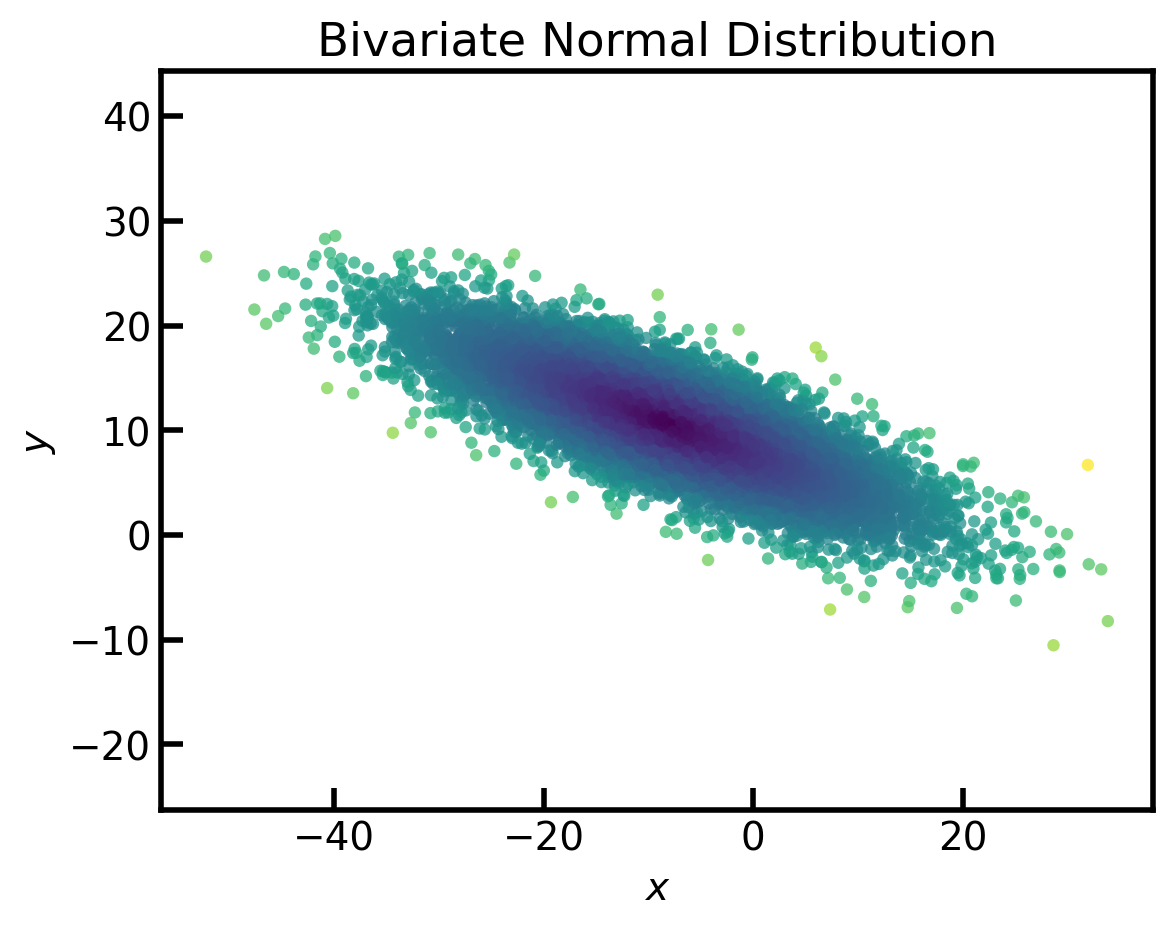

In [12]:
BND_fig, BND_xlim, BND_ylim, rot_angle, _ = BND_scatter_plot(
                                                            BND_x,
                                                            BND_y,
                                                            mu_vec=mu_vec,
                                                            cov_matrix=cov_matrix,
                                                            cmap='viridis'
)


Check that the approximate mean of the distribution in the plot matches what you would expect from the mean generated randomly above. Also, check that the variances in $x$- and $y-$ match what you might predict. How do you see a positive or negative covariance represented in the distribution? You can re-run the BND generation under **(1) (b)** to try out a new distribution.

**(2) Standardize the Sample**

This centers the principal component vector space and puts all variables on the same scale. We assume that $x$ and $y$ are not measured on the same scale by default, and that they do not carry the same units. PCA assumes that data are normally distributed, and it is very sensitive to variances. Standardization brings all variables to the scale of a standard normal distribution - i.e., it calculated "Z-scores" along each dimension, for each measurement.

With variables that have different scalings (dimensions, units), PCA would be biased to always find the direction of maxiumum variance along a dimension where a variable is measured on a very fine scale, i.e., where the numerical values (including variance) are very large. Imagine that $x$ is measured in mm ranging from -1000 to 1000, and $y$ is measured in meters ranging from 0 to 1. These could be measurements of lengths of two distinct objects. Then, even if the two length samples carry the same true variance, the first principal component would be biased to lie closer to the $x$-axis where the nominal variance in units of mm is larger than for $y$ measured in meters. Standardizing by the variance then brings these two varibles to a common scale. PCA can be used for dimensionality reduction even if the units of different variables are not known. What is important is the correlations between variables that allows for PCA to be useful for reducing dimensionality.

If $x$ and $y$ are describing axes of the same 2D plane (like 2D measurements of the position of a stationary object in an image across repeated observations), then we would not scale the data as the difference in variances along the two axes would actually be meaningful in terms of, e.g., the difference in measurement uncertainty between measurements made along either of the axes. In this case it would only be important to ensure that the units of each axis are the same.

If variables have completely different dimensions, i.e., temperatures, lengths, times, masses, etc., then we can bring the measurements to around the origin at similar scales by standardizing the data.

Even if the variances in different variables were already on the same scale, principal components would be biased to lie along axes with much larger nominal means. Given that the PC vector space is defined from the origin, all vectors would have to travel furthest along this dimension to reach the mean of the data, and therfore the direction of maxium variance would only be small deviation from the mean vector that is biased in this dimension—not useful when the mean values of different variables are not comparable to each other in a meaningful sense. Remember, we are looking for linear correlations—how variables vary with each other, not how they vary within themselves or how their means vary.

**(a) Compute Necessary Sample Statistics**

We'll pretend that we don't know the population that this sample was drawn from, and compute the sample means in $x$ and $y$, and the 2-D sample covariance matrix. From the sample covariance matrix, we can extract the sample standard deviations in $x$ and in $y$.

$$\large \langle x \rangle = \frac{1}{n} \sum_{i=1}^{n} x_i$$
$$\large \langle y \rangle = \frac{1}{n} \sum_{i=1}^{n} y_i$$

\begin{equation}\large \hat{\Sigma} =   \begin{bmatrix}
                    s_x^2 & s_{xy}\\
                    s_{yx} & s_y^2
                    \end{bmatrix}\end{equation}

In [13]:
# calculate the means of the sample in x and y
x_mean = np.mean(BND_x)
y_mean = np.mean(BND_y)

# compute the covariance matrix of the sample
# vstack() makes BND_x the first row and BND_y the second row of 2 x n_samples matrix
# ddof=1 => sample variances and covariances (Bessel's correction)
sample_cov_matrix = np.cov(np.vstack([BND_x, BND_y]), ddof=1)

# get the sample standard deviations from the diagonal elements of the sample covariance matrix
x_stdev = sample_cov_matrix[0,0]**(1/2)
y_stdev = sample_cov_matrix[1,1]**(1/2)


**(b) Subtract Sample Means, Divide by $s$**

In [14]:
# We want to bring all variables to the same scale, and centered at the origin for the PCA analysis
BND_x_std = (BND_x - x_mean) / x_stdev
BND_y_std = (BND_y - y_mean) / y_stdev

# compute new means and covariance matrix to check that we did this correctly
x_mean_std = np.mean(BND_x_std)
y_mean_std = np.mean(BND_y_std)


Plot the standardized sample to see what it looks like:

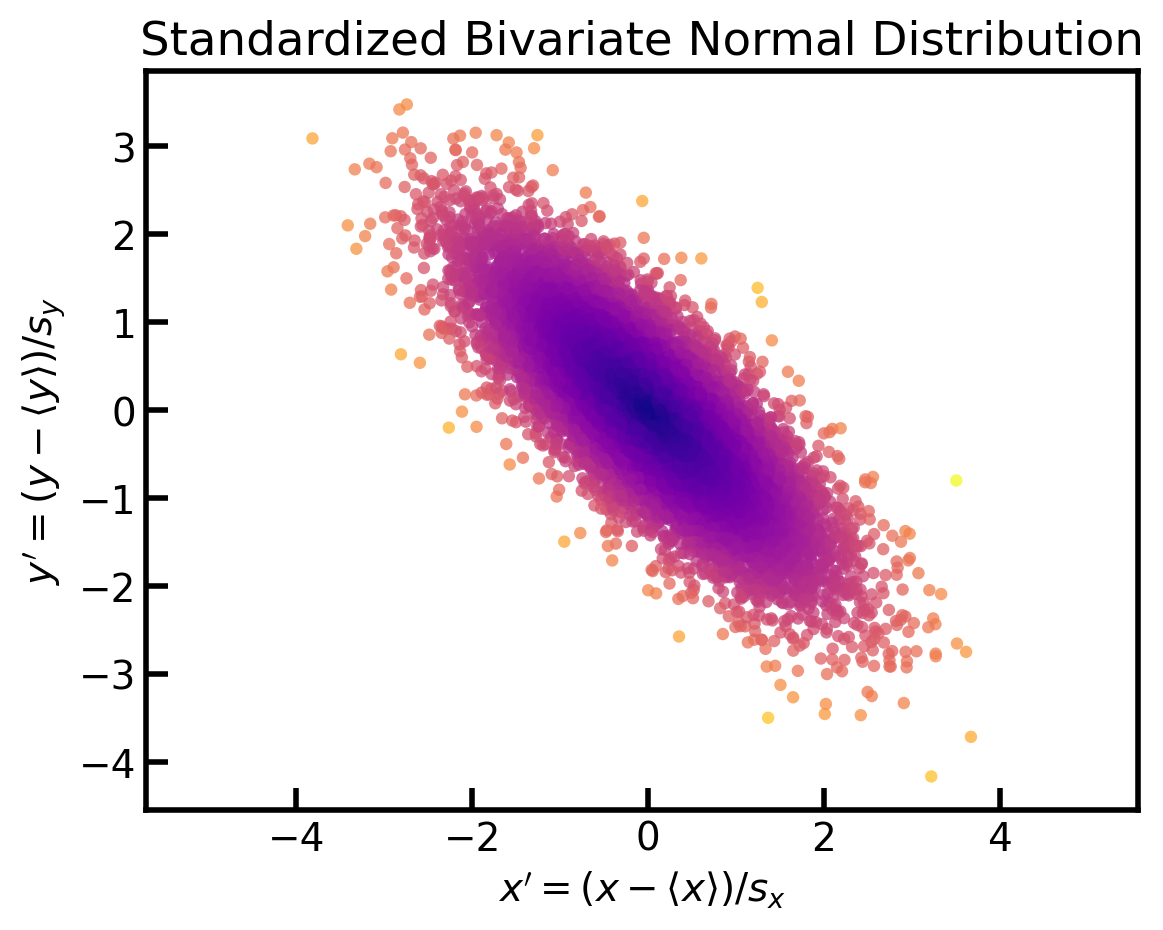

In [15]:
BND_std_fig, xlim_std, ylim_std, rot_angle_std, _ = BND_scatter_plot(
                                                                BND_x_std,
                                                                BND_y_std,
            xlabel=r'$x^\prime = (x - \langle x \rangle) / s_x$',
            ylabel=r'$y^\prime = (y - \langle y \rangle) / s_y$',
            title='Standardized Bivariate Normal Distribution'
)


Notice that the distribution is now centered on the origin, and the axes have been scaled so that the standard deviations in x and y are 1.

In [16]:
print(f"Standardized sample mean <x'>, <y'>:\t\t\t{x_mean_std:.5f}, {y_mean_std:.5f}")
print(f"Standardized sample standard deviation s_x', s_y':\t{np.std(BND_x_std, ddof=1):.5f}, {np.std(BND_y_std, ddof=1):.5f}")


Standardized sample mean <x'>, <y'>:			-0.00000, -0.00000
Standardized sample standard deviation s_x', s_y':	1.00000, 1.00000


**(3) Find Eigenvalues and Eigenvectors of the Covariance Matrix of the Standardized Sample (Principal Components)**

In [17]:
# compute the covariance matrix of the standardized sample
# ddof=1 => sample variances and covariances (Bessel's correction)
std_cov_matrix = np.cov(np.vstack([BND_x_std, BND_y_std]), ddof=1)

# compute the eigenvalues and eigenvectors of the sample covariance matrix
std_evals, std_evecs = la.eig(std_cov_matrix)
std_evals = np.real(std_evals)# get rid of +0j imaginary component

# sort these by the eigenvalues to get the first PC, and then the second PC
# np.flip() to get in decending order - i.e., first PC first
std_evals_sorti = np.flip(np.argsort(std_evals))
std_evals = np.take_along_axis(std_evals, std_evals_sorti, axis=0)
std_evecs = np.take_along_axis(std_evecs, np.vstack((std_evals_sorti, std_evals_sorti)), axis=1)

print(f'Eigenvalues:\t\t{std_evals}')
print(f'\nFor row eigenvectors:\t{std_evecs[:,0]} \n\t\t\t{std_evecs[:,1]}')


Eigenvalues:		[1.79544397 0.20455603]

For row eigenvectors:	[ 0.70710678 -0.70710678] 
			[0.70710678 0.70710678]


The eigenvector with the largest eigenvalue will be the first principal component, and the eigenvector with the smallest eigenvalue will be the second principal component. Notice that the two eigenvectors are perpendicular - principal components are alwasy orthogonal to each other.

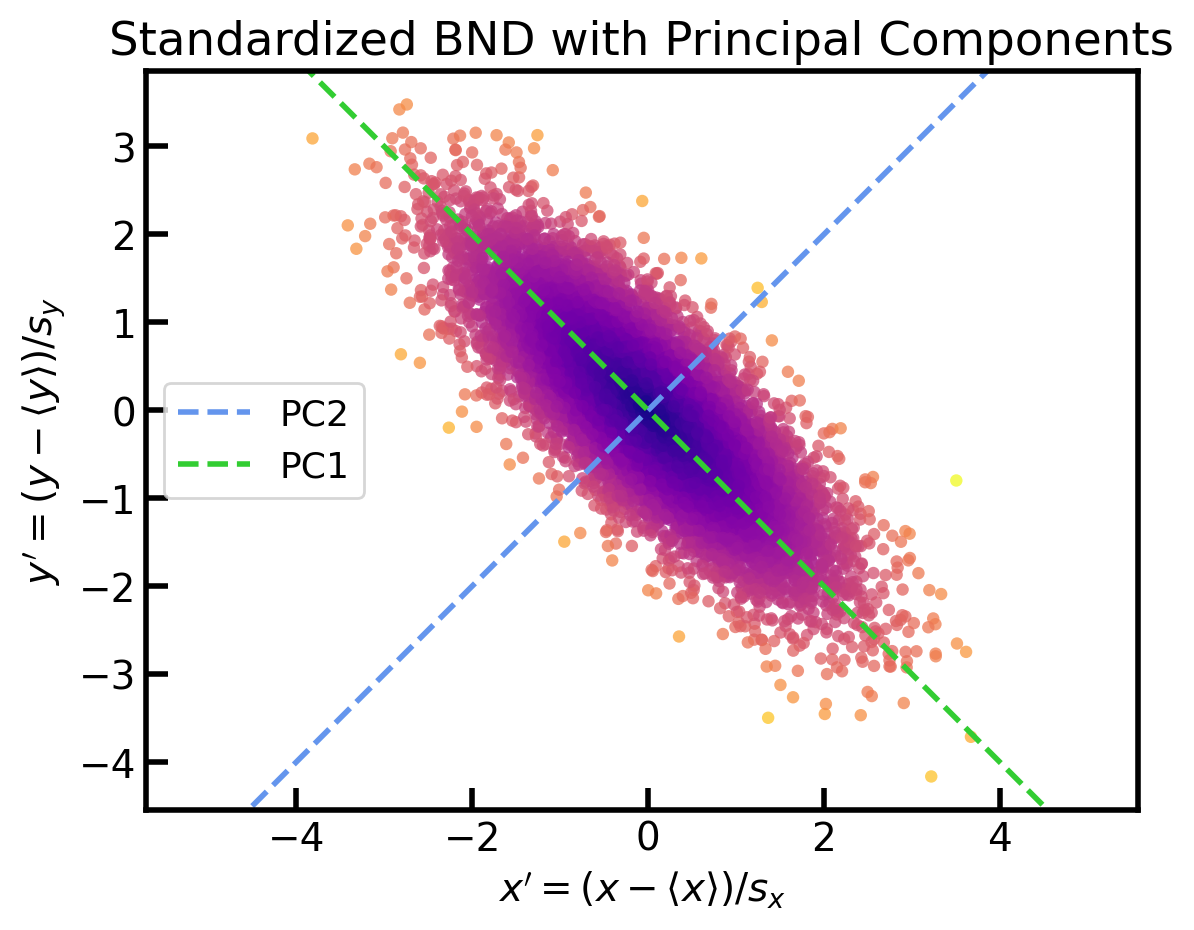

In [18]:
# rise / run for the two eigenvectors (these are column vectors)
m1 = std_evecs[1][0] / std_evecs[0][0]# first index is variable, second is the vector index
m2 = std_evecs[1][1] / std_evecs[0][1]# first index is variable, second is the vector index

# plot the standardized
BND_std_fig_w_vecs, _, _, _, _ = BND_scatter_plot(
    BND_x_std,
    BND_y_std,
    xlabel=r'$x^\prime = (x - \langle x \rangle) / s_x$',
    ylabel=r'$y^\prime = (y - \langle y \rangle) / s_y$',
    title='Standardized BND with Principal Components',
    m1=m1,
    m2=m2,
    std=True,
    xlim=xlim_std,
    ylim=ylim_std
)


Plot these principal coordinates on the un-transformed data, as well

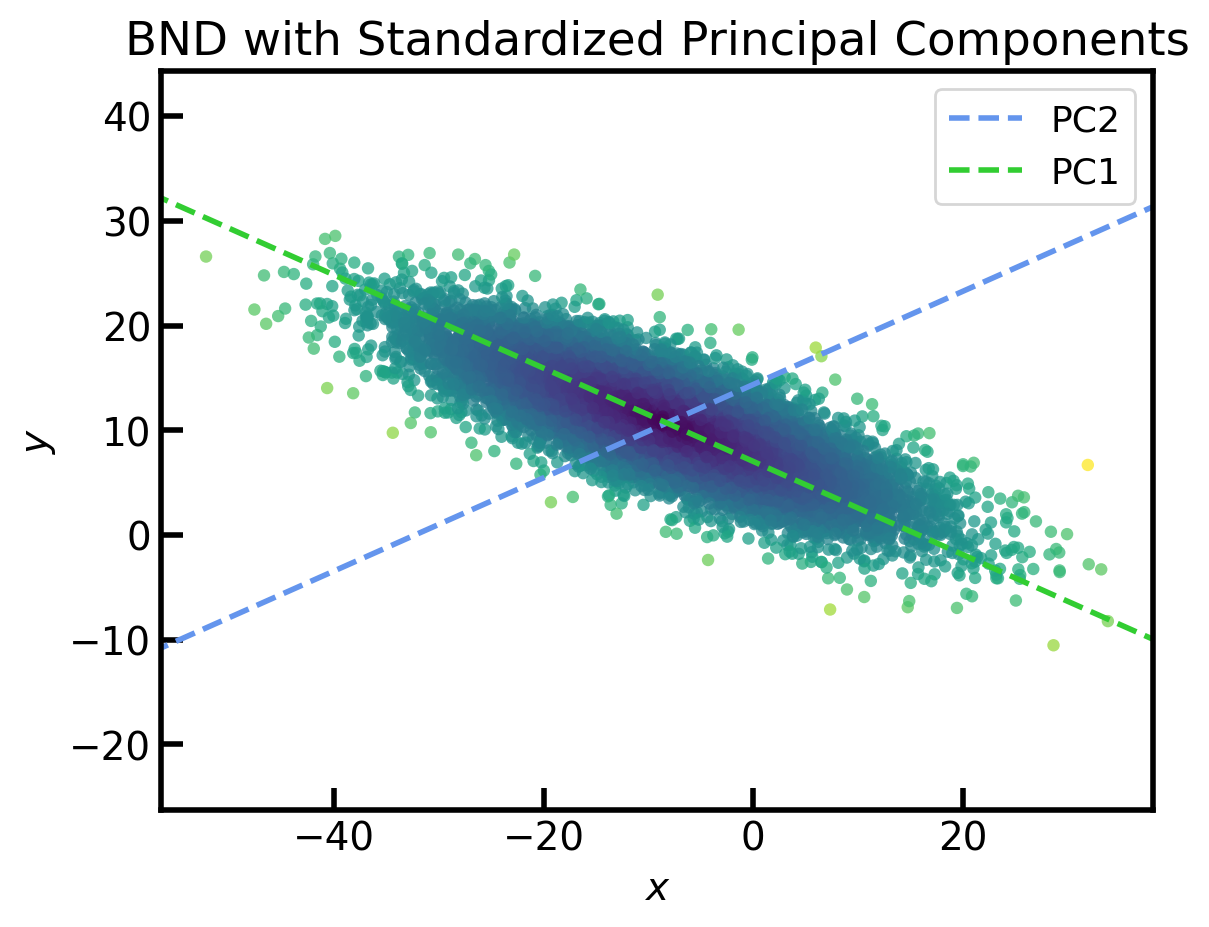

In [19]:
BND_fig_with_std_pcs, _, _, _, _ = BND_scatter_plot(
    BND_x,
    BND_y,
    mu_vec=mu_vec,
    cov_matrix=cov_matrix,
    cmap='viridis',
    m1=m1*y_stdev/x_stdev,
    m2=m2*y_stdev/x_stdev,
    xlim=BND_xlim,
    ylim=BND_ylim,
    title='BND with Standardized Principal Components'
)


Notice that the principal components in the standardized sample are not orthogonal in the original sample, and they don't appear to fall exactly along the two perpindicular directions with maxium variance along PC1 in the orginal sample either.

This plot shows the hidden biases that we might pick up if we did not standardize the data and used the two naive perpendicular axes with maxiumum variance in the not-standardized distribution along the first naive PC. 


**(4) Create Feature Vectors with the Standardized Principal Components**

Choose how many principal components to keep. Here, we can keep just the first PC (green line), or we can keep both to fully represent the data in the new basis of the principal components. No information is lost if we retain $D$ principal components in $d$ dimensions, but the maxiumum possible information is retained in $d < D$ principal components, which is were PCA is useful for dimensionality reduction with the least loss in accuracy possible (there is no losses way to reduce the dimensionality unless the variance of one or more variables in the dataset is exactly 0).

Eigenvectors (PCs) should be ordered columns of the feature vector.

In [20]:
# both principal components as columns
fv_both_pcs = std_evecs# this array already has the two PCs as column vectors

# just the first principal component as a column
fv_1st_pc = std_evecs[:,0]# just the first column vector (first pc)


**(5) Re-Cast the Data to Be Represented in the Principal Component Basis**

**(a) Retain Both Components (Coordinate Transformation)**

Transpose the feature vector so that the eigenvectors are now rows, and stack the standardized $x$- and $y$-data so that they are also rows. Then, take the dot product.

In [21]:
rotated_data_both_pcs = fv_both_pcs.T.dot(np.vstack((BND_x_std, BND_y_std)))


Plot it!

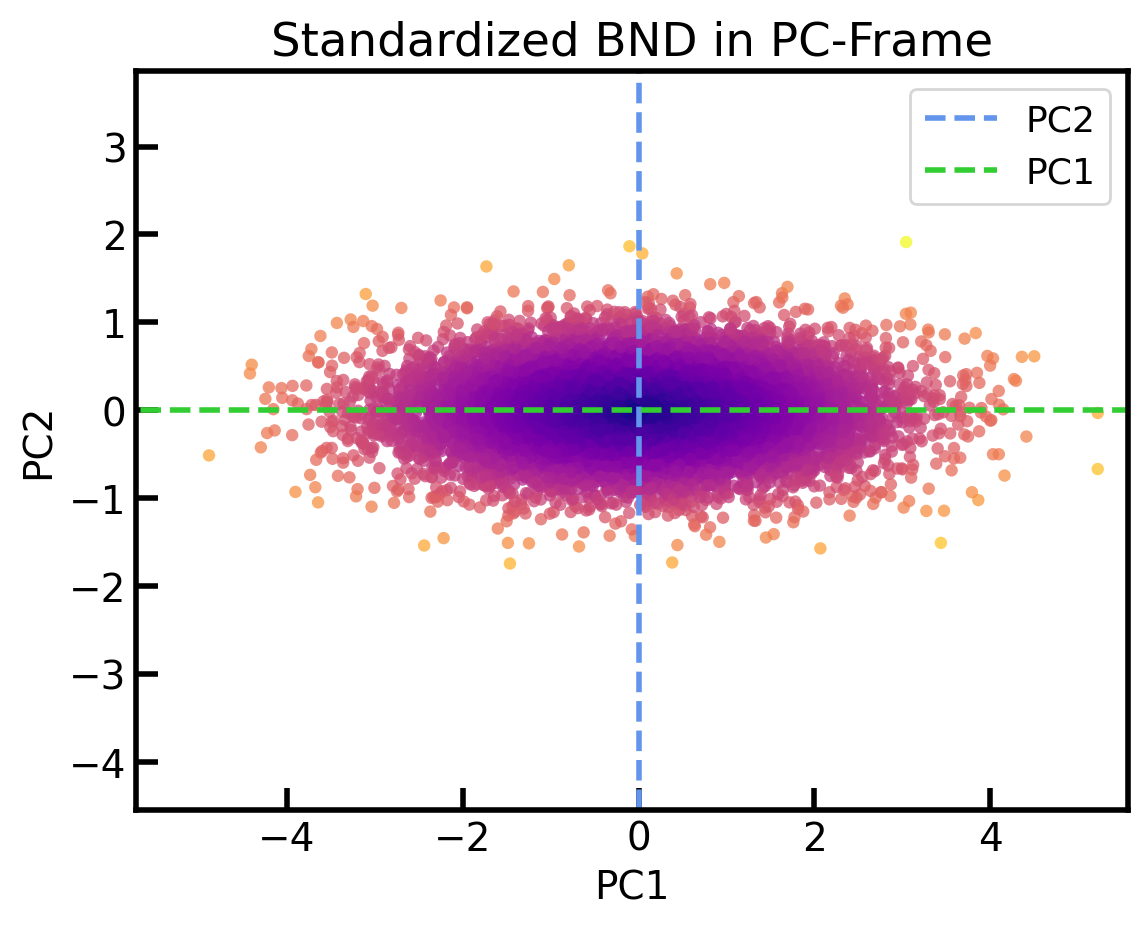

In [22]:
BND_std_fig_both_pcs, _, _, _, cc_std = BND_scatter_plot(
    rotated_data_both_pcs[:][0],
    rotated_data_both_pcs[:][1],
    xlabel='PC1',
    ylabel='PC2',
    title='Standardized BND in PC-Frame',
    m1=0,
    m2=np.inf,
    std=True,
    xlim=xlim_std/np.tan(rot_angle_std),
    ylim=ylim_std/np.tan(rot_angle_std),
    cmap_power=0.5
)


Great! We can now see that the data are normally distributed along the two principal components. This is equivalent to a change in coordinates where we have translated the origin to the mean of the sample, and we have rotated the axes such that the maximum variance is along PC1.

Notice that the two principal components are now *uncorrelated*. The correlations in the data are represented by the directions of the principal component axes themselves in the frame of the standardized sample.

The axes may be backwards—this is a result of the fact that we have projected onto the principal component direction, which are vectors that could just as well be flipped 180 degrees. It is the line that the vector lies along which is important for the projection, giving the magnitudes of the principal components for each data point in the new coordinates.

**(b) Retain Only the First Principal Component (Dimensionality Reduction)**

In [23]:
rotated_data_1st_pc = fv_1st_pc.T.dot(np.vstack((BND_x_std, BND_y_std)))


plot it!

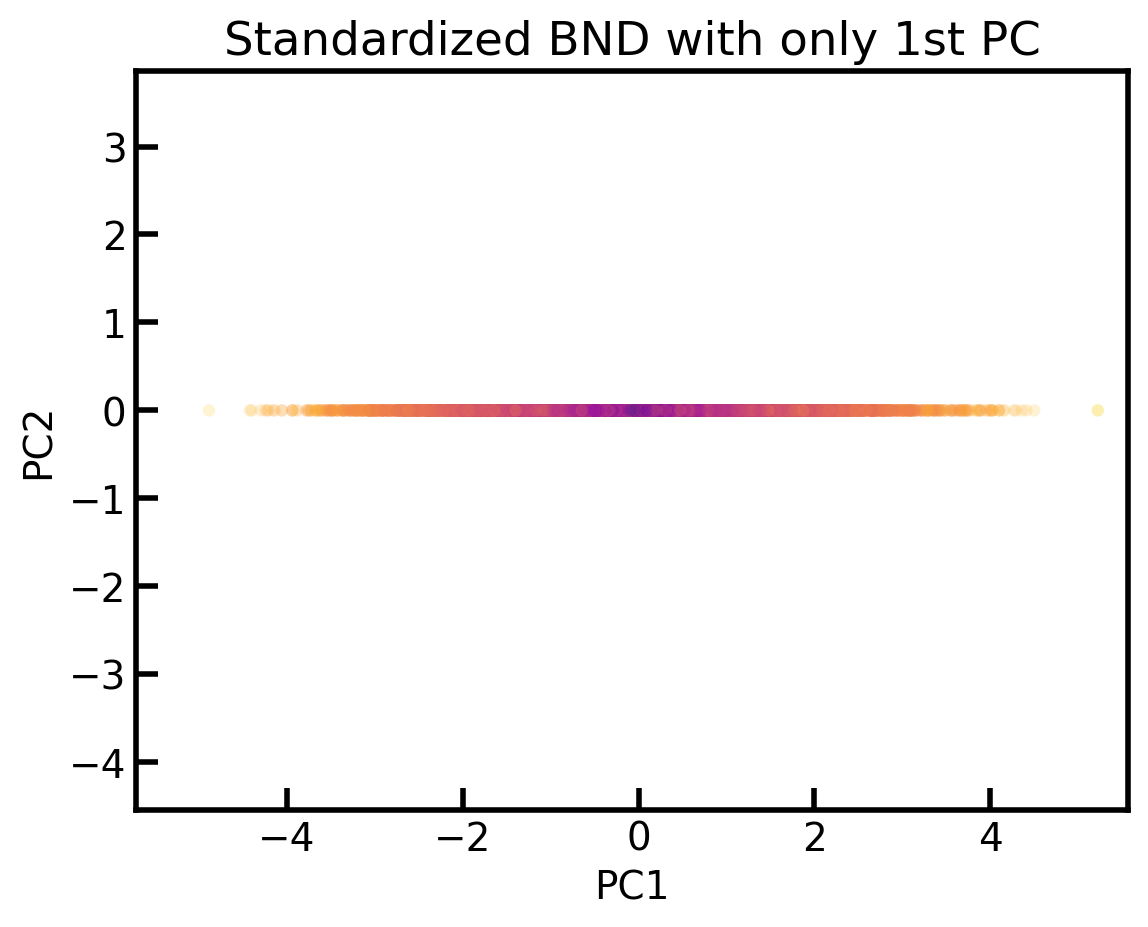

In [24]:
BND_std_fig_1st_pc, _, _, _, _ = BND_scatter_plot(
    rotated_data_1st_pc,
    np.zeros((len(rotated_data_1st_pc),)),
    xlabel='PC1',
    ylabel='PC2',
    title='Standardized BND with only 1st PC',
    std=True,
    xlim=xlim_std / np.tan(rot_angle_std),
    ylim=ylim_std / np.tan(rot_angle_std),
    one_pc=True,
    pc_lines=False,
    cc=cc_std,
    cmap_power=0.5,
    alpha=0.2
)


We have now ideally reduce the dimensionality of the bivariate normal sample to capture the maximum variance in the data possible with only a single variable, PC1. PC1 is a linear combination of the standardized input variables, $x^\prime$ and $y^\prime$, which were centered at the origin and scaled by their standard deviations from $x$ and $y$.

We can see how the plot above this one was "collapsed" --- i.e., projected --- onto the PC1-axis.

Finding PC1 looks similar to a linear regression, but it is slightly different. Linear regression seeks to minimize the sum of squared deviations of the output variable from a linear function. The first PC in this analysis minimizes the *perpendicular* deviations of the data. In practice, PCA is typically applied to input (independent) variables, which may have some correlation that allows for dimensionality reduction. This allows for the creation of a basis with fewer dimensions composed of uncorrelated principal components capturing most of the total variance in the data. Linear regression is applied with an output (dependent) variable as a function of the input variables, where the dependent variable is known or expected to be a linear function of the independent variables.

A big distinction here is the difference between variables being correlated and variables having a function relationship. For example, the heights and weights of humans will be positively correlated, but there is no functional relationship that will map a height to a single weight. In this case, PCA to determine a linear correlation may be more appropriate than linear regression which would seek to describe the non-existent functional relationship. On the other hand, noise that exists purely in a measurement of some dependent variable which is a linear function of an input variable would manifest as a spread of points vertically from a straight line. Linear regression would be more appropriate here for estimating the underlying slope and intercept of the functional relation.

In [25]:
from math import comb

In [30]:
s = 0
for k in range(0,6):
    s += comb(15,k) * (0.5)**k * (0.5)**(15-k)
print(s)

0.15087890625
